<h1 align=center><font size = 5>SPE Europe Energy GeoHackathon</font></h1>

Society of Petroleum Engieers|  ERCE Equipoise | Geothermal Challenge  
:-------------------------:|:-------------------------:|:-------------------------:
<a href="https://www.spehackathon-eu.com"> <img src = "https://upload.wikimedia.org/wikipedia/en/thumb/4/42/Society_of_Petroleum_Engineers_Logo.svg/1200px-Society_of_Petroleum_Engineers_Logo.svg.png" width = 200 /> | <a href="https://www.erce.energy/"> <img src = "https://energycouncil.com/wp-content/uploads/ERCE.png" width = 200/> | <img src = "https://solutions.vallourec.com/-/media/Solutions-img/Low-Carbon-Energy/Medias/Geothermal-energy/Header-Corner_Geothermal.ashx" width = 200/>

<h1 align=center><font size = 4> Team ERCE - Munish Kumar, Kanna Swaminathan & Ivan Maulana </font></h1>
<h1 align=center><font size = 3> 2021 </font></h1>

In [1]:
# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter
from plotnine import *
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from numpy import sqrt 

import seaborn as sns
import math

import time
import re
import requests
import pickle
import os
import glob
import scipy
import sys
import warnings

import plotly.express as px
import plotly.graph_objects as go 

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set()

from sklearn.linear_model import LinearRegression

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
dir_name = r'C:\Users\vasan\OneDrive\02_Impact_Petroleum\09_GeoHackathon_2021\00_Hackathon'
filename_suffix = 'txt'
filename_suffix2 = 'csv'
filename_suffix3 = 'xlsx'

font = {'family': 'arial',
    'color':  'blue',
    'weight': 'normal',
    'size': 16,
   }

In [3]:
#conversion factors
kJ_day_MW = 1/3.6e6/24
m3_day_m3_sec = 1 / (24 * 60 * 60)
pump_efficiency = 0.5
electricity_price = 100 # euro/MWh

In [4]:
#inputs

existingwells = 10
newwells = 6

#location of demand point 1
d1x = 94 
d1y = 65

#location of demand point 2
d2x = 125
d2y = 170


doublets = ["01", "02", "03", "04", "05", "06","09","10"] #Define number of doublets 



In [5]:
#define costs and discount rate

periodic_discount_rate = 0.05

drilling = 4113000
ESP = 400000
VSD = 300000
xmastree = 250000
degasser = 1000000
filters = 4500
heatxchanger = 2000000
injpump = 3000000
CHP = 1600000

In [6]:
# read wells summary and location 
wells = pd.read_excel('WellsInput.xlsx')

In [7]:
#function that computes energy per producer
def EnergyProd2(data):   
    for i in doublets:
        prodE = abs(data['p' + str(i) + ' : energy (kj/day)'])
        injE = abs(data['i' + str(i) + ' : energy (kj/day)'])
        data['System power (MW)' + '_' + str(i)] = (prodE - injE)* kJ_day_MW
        
        data['Produced Energy (MWh)' + '_' + str(i)] = data['System power (MW)' + '_' + str(i)] * data['deltahours']
        
    data['System power (MW) Sum'] = data.filter(regex='^System').sum(1)
    data['Produced Energy (MWh) Sum'] = data.filter(regex='^Produced Energy').sum(1)
    
    data.plot('econ_periods', 'System power (MW) Sum')
    
    fig, ax = plt.subplots(2,2, figsize=(12,6), dpi=150, sharex=True)
    # get plot axes
    ax_list = fig.axes
    
    for i, key in enumerate(['System power (MW)', 'bhp (bar)','temperature (k)', 'water rate (m3/day)']):
        dfBase600.plot(x='time (yrs)',
                 y=dfBase600.filter(like=key).columns.tolist(), 
                 ax=ax_list[i], 
                 linestyle='-', 
                 style=['x', 'o'])
        ax_list[i].legend(fontsize=6)
        ax_list[i].grid(alpha=0.3)
       
    return data.head() 

In [8]:
#Function computes opex of pump
def pumpopex(data, doublets):
    
#    for i in doublets:
#        data = data.filter(like=i)
#        data = data.filter(like=("bhp"))
        
#    pumprate = data.filter(like=("water"))
    
    for i in doublets:
        pumpdp = abs(data['p' + str(i) + ' : bhp (bar)']*0.1) - abs(data['i' + str(i) + ' : bhp (bar)']*0.1)
        data['Pump dp (MPa)' + '_' + str(i)] = pumpdp 
    
        pumppower = abs(data['Pump dp (MPa)' + '_' + str(i)]) * abs(data['p' + str(i) + ' : water rate (m3/day)']) * m3_day_m3_sec * pump_efficiency
        data['Pump power (MW)' + '_' + str(i)] = pumppower
    
        data['OpEx_pump (\u20ac)' + '_' + str(i)] = data['Pump power (MW)' + '_' + str(i)]* data['deltahours'] * electricity_price
       
    return data

In [9]:
#this function returns a datafram with existing well doublets and their cumulative distance from demand locations
def doubletsfn (data):
    data['d1dist (m)'] = (sqrt( (d1x - wells['x_coord'])**2 + (d1y - wells['y_coord'])**2 ))*50
    data['d2dist (m)'] = (sqrt( (d2x - wells['x_coord'])**2 + (d2y - wells['y_coord'])**2 ))*50
    
    d1dist = wells.groupby(wells.Well.str[1:])['d1dist (m)'].sum().to_frame('d1dist').reset_index()
    d2dist = wells.groupby(wells.Well.str[1:])['d2dist (m)'].sum().to_frame('d2dist').reset_index()
    
    data2=pd.merge(d1dist, d2dist, on=['Well'])
    
    return data2

In [10]:
#This function retrieves power on year 1 for each doublets
def doubletsPow (data, wells):
    dfPow = data.filter(regex='^System')
    dfPow.drop(['System power (MW) Sum'], axis=1, inplace=True)
    dfPow = dfPow.iloc[[49]]
    dfPow = dfPow.T
    dfPow = dfPow.reset_index()
    dfPow[['Power','Well']] = dfPow['index'].str.split("_",expand=True)
    
    result=pd.merge(wells, dfPow, on=['Well'])
    result.drop(['index', 'Power',], axis=1, inplace=True)
    result = result.rename({1: 'Power (MW)'}, axis=1)
    
    return result

In [11]:
# this function computes the capex for pipeline
def capexpl(data):
    data['demandloc'] = np.where(data['d1dist'] < data['d2dist'], 0, 1) 
    dfdemand = data.groupby(['demandloc']).sum()
    dfdemand = dfdemand.reset_index()
    dfdemand['demandreq'] = np.where(dfdemand['demandloc'] == 0, 80, 100) 
    
    dfdemand['dfplcost'] = np.where(dfdemand['demandloc'] == 0, (dfdemand['d1dist']/1000)*600000,(dfdemand['d2dist']/1000)*600000 ) 
    
    return dfdemand

In [12]:
#this function computes the capex 
def capex(data, wells, PL):
    count = newwells/2
    countproxy = existingwells/2
    
    Capex = drilling*count*2 + (ESP + VSD + xmastree + degasser + filters + heatxchanger + injpump + CHP)*(countproxy +count) + PL
    CapexTemp = drilling*count*2
    
    # assign the CapEx
    data['CapEx (\u20ac)'] = 0
    data.loc[dfBase600.index == data.index[0], 'CapEx (\u20ac)'] = Capex
#    data['CapexTemp (\u20ac)'] = 0
#    data.loc[dfBase600.index == data.index[0], 'CapexTemp (\u20ac)'] = CapexTemp
    
    return data

In [13]:
#this function computes the levelised Cost of Heat 
#periodic_discount_rate = 0.05
def LCOH (data):
    # compute the LCOH costs
    data['LCOH costs'] = data['CapEx (\u20ac)'].fillna(0) + data['OpEx (\u20ac)'] + data['OpEx_pump (\u20ac)'].fillna(0)
    
    # discount LCOH costs
    data['discounted LCOH costs'] = (data['LCOH costs'] /
                                      (1 + periodic_discount_rate) ** data['econ_periods']).cumsum()
    
    data['discounted LCOH energy'] = (data['Produced Energy (MWh) Sum'] /
                                        (1 + periodic_discount_rate) ** data[
                                            'econ_periods']).cumsum()
    data[r'LCOH (€/MWh)'] = data['discounted LCOH costs'] / data['discounted LCOH energy']
    
    dfBase600.plot('econ_periods', 'LCOH (€/MWh)')
    
    return data

In [14]:
#function that return final econ plots
def plotecon(data): 
    fig, ax = plt.subplots(2,3, figsize=(12,8), dpi=150, sharex=True)
    # get plot axes
    ax_list = fig.axes
    
    # plot a few keywords in pairs for both wells
    
    for i, key in enumerate(['temperature', 'bhp','water rate (m3/day)',
                             'power', 'Ex','LCOH (€/MWh)']):
        data.plot(x='econ_periods',
                  y=data.filter(like=key).columns.tolist(),
                  ax=ax_list[i],
                  linestyle='-',
                  style=['x', 'o'])
        ax_list[i].legend(fontsize=6)
        ax_list[i].grid(alpha=0.3)
        if key == 'LCOH (€/MWh)':
            ax_list[i].annotate('%0.2f @ time: %.2f yrs' % (data[key].iloc[-1], dfBase600['econ_periods'].iloc[-1]),
                                xy=(0.5, 0.5), va='center', ha='center',
                                xycoords=('axes fraction'))

In [15]:
#function computes the economic parameters
def netpv(data):
    data['CapEx (MM€)'] = data['CapEx (€)']/1000000
    data['OpEx (MM€)'] = data['OpEx (€)']/1000000
    data['OpEx_pump (MM€)'] = data['OpEx_pump (€)']/1000000

    data['Revenue (MM€)'] = np.where(data['System power (MW) Sum'] < 180, ((data['System power (MW) Sum']* data['deltahours'])* electricity_price)/1000000,
                                     ((180* data['deltahours'])* electricity_price)/1000000)
    #data['Revenue (MM€)'] = (data['System power (MW) Sum'] * data['deltahours'] * electricity_price)/1000000
    data['NCF (MM€)'] = data['Revenue (MM€)'] - data['CapEx (MM€)'].fillna(0) - data['OpEx (MM€)']  - data['OpEx_pump (MM€)'].fillna(0)
    data['pv (MM€)'] = data['NCF (MM€)'] / (1 + periodic_discount_rate) ** data['econ_periods']
    
    return data 

In [16]:
#function plots econ parameters
def plotecon2(data): 
    fig, ax = plt.subplots(2,3, figsize=(12,8), dpi=150, sharex=True)
    # get plot axes
    ax_list = fig.axes
    
    # plot a few keywords in pairs for both wells
    
    npv = data['pv (MM€)'].sum()
    
    for i, key in enumerate(['pv (MM€)', 'Revenue (MM€)','NCF (MM€)',
                             'OpEx (MM€)', 'CapEx (MM€)','LCOH (€/MWh)']):
        data.plot(x='econ_periods',
                  y=data.filter(like=key).columns.tolist(),
                  ax=ax_list[i],
                  linestyle='-',
                  style=['x', 'o'])
        ax_list[i].legend(fontsize=6)
        ax_list[i].grid(alpha=0.3)
        if key == 'LCOH (€/MWh)':
            ax_list[i].annotate('%0.2f @ time: %.2f yrs' % (data[key].iloc[-1], data['econ_periods'].iloc[-1]),
                                xy=(0.5, 0.5), va='center', ha='center',
                                xycoords=('axes fraction'))
        elif key == 'pv (MM€)':
            ax_list[i].annotate('NPV is €' + str(npv),
                                xy=(0.8, 0.7), va='center', ha='center',
                                xycoords=('axes fraction'))
            

We pass the input file and chck for missing or zero values. We fill those missing values as needed.

In [17]:
dfBase600 = pd.read_csv('R36_8Db_R24dup_Db04_700_05_10_06_SouthB2_2000_mod.csv')

In [18]:
dfBase600.isna().sum()

unnamed: 0                   0
p10 : energy (kj/day)        0
i10 : bhp (bar)              0
i01 : energy (kj/day)        0
p03 : energy (kj/day)        0
                            ..
i10 : water rate (m3/day)    0
p09 : temperature (k)        0
time (yrs)                   0
econ_periods                 0
deltahours                   1
Length: 76, dtype: int64

In [19]:
dfBase600 = dfBase600.fillna(0)

In [20]:
dfBase600.head()

,unnamed: 0,p10 : energy (kj/day),i10 : bhp (bar),i01 : energy (kj/day),p03 : energy (kj/day),i05 : energy (kj/day),i05 : temperature (k),i05 : water rate (m3/day),i04 : water rate (m3/day),i02 : temperature (k),...,p04 : energy (kj/day),p04 : bhp (bar),p06 : water rate (m3/day),p06 : energy (kj/day),p05 : water rate (m3/day),i10 : water rate (m3/day),p09 : temperature (k),time (yrs),econ_periods,deltahours
0,0.0,-3.846149e-01,229.153509,1.743783e-02,-1.842289e+00,-6.206008e-02,349.132467,-1.877777e-07,-0.000024,343.624054,...,-2.642227e+00,185.124496,-0.000002,-8.223315e-01,-0.000002,1.825042e-07,353.133641,0.0,0,0.0
1,8.0,-3.264715e+09,233.627161,1.066004e+09,-2.852556e+09,1.071370e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,-5.631159e+09,165.349374,-12000.000000,-4.216556e+09,-8400.000000,1.080000e+04,351.970371,1.0,1,8760.0
2,9.0,-3.286051e+09,234.189370,1.066210e+09,-2.849303e+09,1.071561e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,-5.654447e+09,164.750533,-12000.000000,-4.208610e+09,-8400.000000,1.080000e+04,352.018192,2.0,2,8760.0
3,10.0,-3.307129e+09,234.905535,1.066829e+09,-2.847230e+09,1.072117e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,-5.678453e+09,164.702853,-12000.000000,-4.205650e+09,-8400.000000,1.080000e+04,352.059118,3.0,3,8760.0
4,11.0,-3.327558e+09,235.488648,1.067350e+09,-2.845392e+09,1.072596e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,-5.702313e+09,164.745765,-12000.000000,-4.204807e+09,-8400.000000,1.080000e+04,352.094217,4.0,4,8760.0


In [21]:
# check conservation of water produced and injected 
WaterTotal = dfBase600.filter(like='(m3/day)')

WaterTotalP = WaterTotal.filter(regex='^p')
WaterTotalP = WaterTotalP.reindex(sorted(WaterTotalP.columns), axis=1)

WaterTotali = WaterTotal.filter(regex='^i')
WaterTotali = WaterTotali.reindex(sorted(WaterTotali.columns), axis=1)

WaterTotalP['PTotal'] = WaterTotalP.sum(axis=1)
WaterTotali['iTotal'] = WaterTotali.sum(axis=1)
#WaterTotalisum = WaterTotali.sum() 
#df['Total'] = df.sum(axis=1)

In [22]:
Total = WaterTotalP['PTotal'].sum()
print ("Total amount of Produced Water: ", Total)

Total amount of Produced Water:  -3984119.999903443


In [23]:
WaterTotalP.head(3)

,p01 : water rate (m3/day),p02 : water rate (m3/day),p03 : water rate (m3/day),p04 : water rate (m3/day),p05 : water rate (m3/day),p06 : water rate (m3/day),p09 : water rate (m3/day),p10 : water rate (m3/day),PTotal
0,-1.617861e-07,-6.055927e-08,-0.000005,-0.000008,-0.000002,-0.000002,-8.300688e-07,-0.000001,-0.00002
1,-8.400000e+03,-7.560000e+03,-8400.000000,-16800.000000,-8400.000000,-12000.000000,-5.760000e+03,-10800.000000,-78120.00000
2,-8.400000e+03,-7.560000e+03,-8400.000000,-16800.000000,-8400.000000,-12000.000000,-5.760000e+03,-10800.000000,-78120.00000


In [24]:
WaterTotali.head(3)

,i01 : water rate (m3/day),i02 : water rate (m3/day),i03 : water rate (m3/day),i04 : water rate (m3/day),i05 : water rate (m3/day),i06 : water rate (m3/day),i09 : water rate (m3/day),i10 : water rate (m3/day),iTotal
0,1.376753e-07,0.0,-1.372648e-08,-0.000024,-1.877777e-07,-0.000014,-1.204592e-07,1.825042e-07,-0.000038
1,8.400000e+03,7560.0,8.400000e+03,16800.000000,8.400000e+03,12000.000000,5.760000e+03,1.080000e+04,78120.000000
2,8.400000e+03,7560.0,8.400000e+03,16800.000000,8.400000e+03,12000.000000,5.760000e+03,1.080000e+04,78120.000000


We confirm that the amount of water produced is the same as the amout of water reinjected into the system, in line with conservation of mass (and energy).

In [25]:
(WaterTotalP['PTotal'] + WaterTotali['iTotal']).head()

0   -5.779904e-05
1   -6.635673e-09
2   -1.123408e-08
3    2.910383e-10
4    2.347224e-08
dtype: float64

We evaluate the mean water rate per day of a single injector well.

In [26]:
(WaterTotali['i09 : water rate (m3/day)']/24).mean()

235.38461538435985

,unnamed: 0,p10 : energy (kj/day),i10 : bhp (bar),i01 : energy (kj/day),p03 : energy (kj/day),i05 : energy (kj/day),i05 : temperature (k),i05 : water rate (m3/day),i04 : water rate (m3/day),i02 : temperature (k),...,System power (MW)_05,Produced Energy (MWh)_05,System power (MW)_06,Produced Energy (MWh)_06,System power (MW)_09,Produced Energy (MWh)_09,System power (MW)_10,Produced Energy (MWh)_10,System power (MW) Sum,Produced Energy (MWh) Sum
0,0.0,-3.846149e-01,229.153509,1.743783e-02,-1.842289e+00,-6.206008e-02,349.132467,-1.877777e-07,-0.000024,343.624054,...,6.612173e-09,0.000000,-5.371874e-08,-0.000000,2.851260e-09,0.000000,4.183661e-09,0.000000,-9.143161e-08,0.000000e+00
1,8.0,-3.264715e+09,233.627161,1.066004e+09,-2.852556e+09,1.071370e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,1.500985e+01,131486.252903,3.109963e+01,272432.792539,1.396645e+01,122346.092777,2.187364e+01,191613.102139,1.810765e+02,1.586230e+06
2,9.0,-3.286051e+09,234.189370,1.066210e+09,-2.849303e+09,1.071561e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,1.523271e+01,133438.524493,3.099854e+01,271547.235486,1.396986e+01,122376.007651,2.211319e+01,193711.551513,1.816130e+02,1.590930e+06
3,10.0,-3.307129e+09,234.905535,1.066829e+09,-2.847230e+09,1.072117e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,1.543243e+01,135188.079069,3.095360e+01,271153.552298,1.397498e+01,122420.852808,2.234774e+01,195766.225243,1.822077e+02,1.596139e+06
4,11.0,-3.327558e+09,235.488648,1.067350e+09,-2.845392e+09,1.072596e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,1.561833e+01,136816.582968,3.093504e+01,270990.908198,1.398022e+01,122466.690322,2.257652e+01,197770.355126,1.828149e+02,1.601459e+06


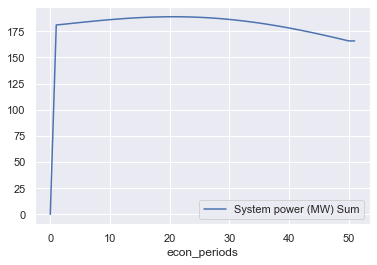

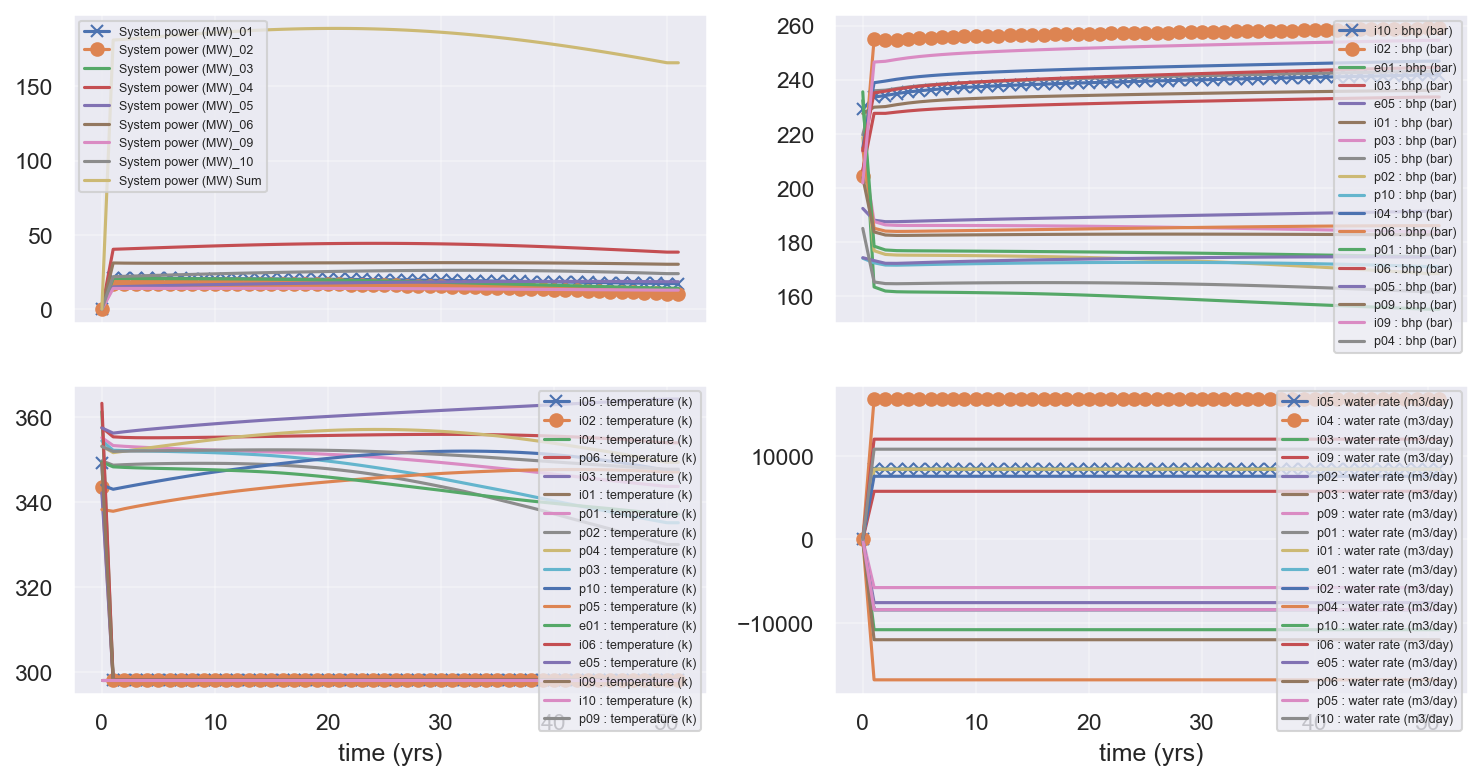

In [27]:
# compute energy produced
EnergyProd2(dfBase600)

In [28]:
# compute opex due to pumping
df2 = pumpopex(dfBase600,doublets)
dfBase600['OpEx_pump (\u20ac)'] = df2.filter(regex='^OpEx').sum(1)
dfBase600['Pump power (MW)_total'] = df2.filter(regex='^Pump power').sum(1)

In [29]:
df2.filter(regex='^OpEx').head()

,OpEx_pump (€)_01,OpEx_pump (€)_02,OpEx_pump (€)_03,OpEx_pump (€)_04,OpEx_pump (€)_05,OpEx_pump (€)_06,OpEx_pump (€)_09,OpEx_pump (€)_10,OpEx_pump (€)
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,218522.606319,298927.776007,170106.565274,626626.477855,267096.233573,304172.024116,183162.177999,335089.981324,2.403704e+06
2,225510.272278,302990.087187,175360.364555,636949.830235,272221.843122,314283.216470,187329.171969,342697.811497,2.457343e+06
3,229500.717933,304933.733716,178152.765532,643035.979630,275009.626101,319511.528753,189759.956678,346873.818037,2.486778e+06
4,232229.268287,306253.560156,180058.996721,647298.507603,276812.376489,323021.504665,191452.053514,349634.987157,2.506761e+06


In [30]:
pumpdp = abs(dfBase600['p01 : bhp (bar)']*0.1) - abs(dfBase600['i01 : bhp (bar)']*0.1)
pumpdp.head()

0    0.481565
1   -5.131646
2   -5.295740
3   -5.389449
4   -5.453525
dtype: float64

In [31]:
pumppower = abs(pumpdp) * abs(dfBase600['p01 : water rate (m3/day)']) * m3_day_m3_sec * pump_efficiency

In [32]:
abs(dfBase600['p01 : water rate (m3/day)']).head(3)

0    1.617861e-07
1    8.400000e+03
2    8.400000e+03
Name: p01 : water rate (m3/day), dtype: float64

In [33]:
pumppower.head()

0    4.508711e-13
1    2.494550e-01
2    2.574318e-01
3    2.619871e-01
4    2.651019e-01
dtype: float64

In [34]:
m3_day_m3_sec
electricity_price

100

In [35]:
opexdp = pumppower* dfBase600['deltahours'] * electricity_price
opexdp.head()

0         0.000000
1    218522.606319
2    225510.272278
3    229500.717933
4    232229.268287
dtype: float64

In [36]:
df2.filter(regex='^OpEx').head()

,OpEx_pump (€)_01,OpEx_pump (€)_02,OpEx_pump (€)_03,OpEx_pump (€)_04,OpEx_pump (€)_05,OpEx_pump (€)_06,OpEx_pump (€)_09,OpEx_pump (€)_10,OpEx_pump (€)
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,218522.606319,298927.776007,170106.565274,626626.477855,267096.233573,304172.024116,183162.177999,335089.981324,2.403704e+06
2,225510.272278,302990.087187,175360.364555,636949.830235,272221.843122,314283.216470,187329.171969,342697.811497,2.457343e+06
3,229500.717933,304933.733716,178152.765532,643035.979630,275009.626101,319511.528753,189759.956678,346873.818037,2.486778e+06
4,232229.268287,306253.560156,180058.996721,647298.507603,276812.376489,323021.504665,191452.053514,349634.987157,2.506761e+06


In [37]:
df2.filter(like='bhp').head()

,i10 : bhp (bar),i02 : bhp (bar),e01 : bhp (bar),i03 : bhp (bar),e05 : bhp (bar),i01 : bhp (bar),p03 : bhp (bar),i05 : bhp (bar),p02 : bhp (bar),p10 : bhp (bar),i04 : bhp (bar),p06 : bhp (bar),p01 : bhp (bar),i06 : bhp (bar),p05 : bhp (bar),p09 : bhp (bar),i09 : bhp (bar),p04 : bhp (bar)
0,229.153509,204.368622,235.548029,206.634874,192.506421,227.560093,214.261127,219.645628,218.717735,174.096183,214.835559,214.676005,232.375744,213.821530,174.313417,203.919507,201.928461,185.124496
1,233.627161,254.887856,163.497029,227.616488,188.155035,229.888250,187.669741,235.955358,176.889741,172.423511,238.925869,185.176385,178.571787,235.177265,173.232172,183.832655,246.559428,165.349374
2,234.189370,254.571745,161.998808,227.613313,187.608736,230.120953,186.432797,236.172984,175.513666,171.596162,239.539163,184.140166,177.163550,235.803160,172.246132,182.684513,246.838339,164.750533
3,234.905535,254.854611,161.738499,228.075579,187.621229,230.819449,186.239313,236.803332,175.289384,171.549587,240.206099,184.013169,176.924955,236.535612,172.221815,182.536847,247.523134,164.702853
4,235.488648,255.151884,161.670783,228.498546,187.724683,231.407019,186.214633,237.347339,175.242280,171.628376,240.749504,184.040781,176.871770,237.140207,172.342475,182.550840,248.116611,164.745765


In [38]:
#compute power produced per doublet
dfdist = doubletsfn(wells)
dfWells = doubletsPow (dfBase600, dfdist)

In [39]:
dfdist

,Well,d1dist,d2dist
0,01,9269.889823,8354.301426
1,02,5732.216992,9325.413012
2,03,5701.562119,5760.629430
3,04,7091.725104,16674.450035
4,05,5399.426034,14200.552400
5,06,3682.270685,9783.975764
6,07,4486.925451,2798.660394
7,08,5056.184332,6103.277808
8,09,12295.785250,3200.000000
9,10,3863.495984,14749.626709


In [40]:
dfWells

,Well,d1dist,d2dist,49
0,01,9269.889823,8354.301426,17.378619
1,02,5732.216992,9325.413012,10.795418
2,03,5701.562119,5760.629430,14.300419
3,04,7091.725104,16674.450035,38.778710
4,05,5399.426034,14200.552400,18.533396
5,06,3682.270685,9783.975764,30.357942
6,09,12295.785250,3200.000000,12.861533
7,10,3863.495984,14749.626709,24.168923


Create column of which_cluster

In [41]:
dfWells.rename(columns={49:'Power (MW)'}, inplace=True)
dfWells['which_cluster'] = np.where(dfWells['d1dist']<dfWells['d2dist'],1,2)
dfWells

,Well,d1dist,d2dist,Power (MW),which_cluster
0,01,9269.889823,8354.301426,17.378619,2
1,02,5732.216992,9325.413012,10.795418,1
2,03,5701.562119,5760.629430,14.300419,1
3,04,7091.725104,16674.450035,38.778710,1
4,05,5399.426034,14200.552400,18.533396,1
5,06,3682.270685,9783.975764,30.357942,1
6,09,12295.785250,3200.000000,12.861533,2
7,10,3863.495984,14749.626709,24.168923,1


Fitting the support vector classifier

In [42]:
# Creating an SVC object from sklearn's SVM class
# The classifier is using a Linear Kernel and the regularization parameter for soft margin (C) is set to 10
cls = svm.SVC(C = 10, kernel='linear')

# Fit SVM classifier to data
print(cls.fit (dfWells[['d1dist', 'd2dist']], dfWells['which_cluster']))
print ("\n Number of Support vectors:", len(cls.support_vectors_))

SVC(C=10, kernel='linear')

 Number of Support vectors: 3


Plot points and SVM decision boundaries

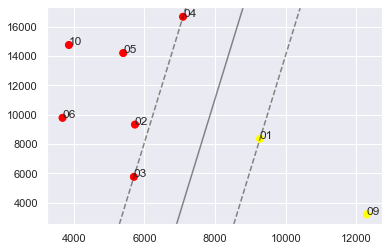

In [43]:
plt.scatter (dfWells['d1dist'], dfWells['d2dist'], c=dfWells['which_cluster'], s=50, cmap='autumn')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
    
# create grid to evaluate model
x = np.linspace(xlim[0], xlim[1], 30)
y = np.linspace(ylim[0], ylim[1], 30)
Y, X = np.meshgrid(y, x)
xy = np.vstack([X.ravel(), Y.ravel()]).T
P = cls.decision_function(xy).reshape(X.shape)

# plot decision boundary and margins
ax.contour(X, Y, P, colors='k',
            levels=[-1, 0,  1], alpha=0.5,
            linestyles=['--', '-' ,'--'])
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# annotate points in axis
for idx, row in dfWells.iterrows():
    plt.annotate(row['Well'], (row['d1dist'], row['d2dist']) )

##### From the SVC hyperplane above, we observe that while 01 and 09 form the yellow cluster, the locations 04 and 03 are sufficiently close such that they are withing the proximity of the yellow points

How much power for each demand location?

In [44]:
System_power_D1 = dfWells.loc[dfWells['which_cluster'] == 1, 'Power (MW)'].sum()
System_power_D2 = dfWells.loc[dfWells['which_cluster'] == 2, 'Power (MW)'].sum()

print("Cluster D1 has",System_power_D1,"MW.")
print("Cluster D2 has",System_power_D2,"MW.")

Cluster D1 has 136.93480775381389 MW.
Cluster D2 has 30.240151546955346 MW.


How much power in support vectors from Cluster D1?

In [45]:
#print(cls.support_)
dfWells.iloc[np.r_[2,3], 3].sum()

53.07912942391553

In [46]:
#duplicate_well = dfWells.iloc[4,:]
#dfdemand = dfWells.append(duplicate_well)
#dfdemand.reset_index(drop=True, inplace=True)
#dfdemand.loc[4, "Power (MW)"] = 25.186993-10.6
#dfdemand.loc[8, "Power (MW)"] = 10.6
dfdemand = dfWells
dfdemand.loc[np.r_[2,3], "which_cluster"] = 2

Updated_D1 = dfdemand.loc[dfdemand['which_cluster'] == 1, 'Power (MW)'].sum()
Updated_D2 = dfdemand.loc[dfdemand['which_cluster'] == 2, 'Power (MW)'].sum()

print(dfdemand)
print("Cluster D1 now has",Updated_D1,"MW.")
print("Cluster D2 now has",Updated_D2,"MW.")

  Well        d1dist        d2dist  Power (MW)  which_cluster
0   01   9269.889823   8354.301426   17.378619              2
1   02   5732.216992   9325.413012   10.795418              1
2   03   5701.562119   5760.629430   14.300419              2
3   04   7091.725104  16674.450035   38.778710              2
4   05   5399.426034  14200.552400   18.533396              1
5   06   3682.270685   9783.975764   30.357942              1
6   09  12295.785250   3200.000000   12.861533              2
7   10   3863.495984  14749.626709   24.168923              1
Cluster D1 now has 83.85567832989835 MW.
Cluster D2 now has 83.31928097087088 MW.


In [47]:
#assign doublets to demand locations and compute capex due to pipelines
dfdemand['dfplcost'] = np.where(dfdemand['which_cluster'] == 1, (dfdemand['d1dist']/1000)*600000,(dfdemand['d2dist']/1000)*600000 )
dfdemand

,Well,d1dist,d2dist,Power (MW),which_cluster,dfplcost
0,01,9269.889823,8354.301426,17.378619,2,5.012581e+06
1,02,5732.216992,9325.413012,10.795418,1,3.439330e+06
2,03,5701.562119,5760.629430,14.300419,2,3.456378e+06
3,04,7091.725104,16674.450035,38.778710,2,1.000467e+07
4,05,5399.426034,14200.552400,18.533396,1,3.239656e+06
5,06,3682.270685,9783.975764,30.357942,1,2.209362e+06
6,09,12295.785250,3200.000000,12.861533,2,1.920000e+06
7,10,3863.495984,14749.626709,24.168923,1,2.318098e+06


In [48]:
#compute total cost due to pipeline
PL = dfdemand['dfplcost'].sum()
PL

31600074.35108572

In [49]:
#compute Capex
dfBase600 = capex(dfBase600, dfWells, PL)

In [50]:
dfBase600.head(3)

,unnamed: 0,p10 : energy (kj/day),i10 : bhp (bar),i01 : energy (kj/day),p03 : energy (kj/day),i05 : energy (kj/day),i05 : temperature (k),i05 : water rate (m3/day),i04 : water rate (m3/day),i02 : temperature (k),...,OpEx_pump (€)_06,Pump dp (MPa)_09,Pump power (MW)_09,OpEx_pump (€)_09,Pump dp (MPa)_10,Pump power (MW)_10,OpEx_pump (€)_10,OpEx_pump (€),Pump power (MW)_total,CapEx (€)
0,0.0,-3.846149e-01,229.153509,1.743783e-02,-1.842289e+00,-6.206008e-02,349.132467,-1.877777e-07,-0.000024,343.624054,...,0.000000,0.199105,9.564263e-13,0.000000,-5.505733,3.998646e-11,0.000000,0.000000e+00,2.571595e-10,1.247141e+08
1,8.0,-3.264715e+09,233.627161,1.066004e+09,-2.852556e+09,1.071370e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,304172.024116,-6.272677,2.090892e-01,183162.177999,-6.120365,3.825228e-01,335089.981324,2.403704e+06,2.743954e+00,0.000000e+00
2,9.0,-3.286051e+09,234.189370,1.066210e+09,-2.849303e+09,1.071561e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,314283.216470,-6.415383,2.138461e-01,187329.171969,-6.259321,3.912075e-01,342697.811497,2.457343e+06,2.805186e+00,0.000000e+00


In [51]:
#compute Opex
periodic_OpEx_rate = 0.07
# calculate variable OpEx costs
dfBase600['OpEx (\u20ac)'] = dfBase600['CapEx (\u20ac)'].cumsum() * periodic_OpEx_rate
#dfBase600['OpexTemp1 (\u20ac)'] = dfBase600['CapEx (\u20ac)'].cumsum() * periodic_OpEx_rate
#dfBase600['OpexTemp2 (\u20ac)'] = dfBase600['CapexTemp (\u20ac)'].cumsum() * periodic_OpEx_rate
#dfBase600['OpEx (\u20ac)'] =dfBase600['OpexTemp1 (\u20ac)'] + dfBase600['OpexTemp2 (\u20ac)']


In [52]:
#compute capex and opex for initial years
print(dfBase600['CapEx (\u20ac)'][0]/1000000)
print(dfBase600['CapEx (\u20ac)'][1]/1000000)
print(dfBase600['OpEx (\u20ac)'][0]/1000000)
print(dfBase600['OpEx (\u20ac)'][1]/1000000)
print(dfBase600['OpEx_pump (\u20ac)'][0]/1000000)
print(dfBase600['OpEx_pump (\u20ac)'][1]/1000000)

124.71407435108573
0.0
8.729985204576
8.729985204576
0.0
2.403703842466235


In [53]:
#compute total opex for project for 50  and 20 years
opex50 = (dfBase600['OpEx_pump (\u20ac)'].sum() + dfBase600['OpEx (\u20ac)'].sum())/1000000
opex20 = (dfBase600['OpEx_pump (\u20ac)'].iloc[0:19].sum() + dfBase600['OpEx (\u20ac)'].iloc[0:19].sum())/1000000

print(opex50)
print(opex20)

588.8565315375239
211.73163005474186


In [54]:
#see head of final df
dfBase600['System power (MW) Sum'].tail()

47    169.834907
48    168.516698
49    167.174959
50    165.809438
51    165.809438
Name: System power (MW) Sum, dtype: float64

In [55]:
dfBase600['System power (MW) Sum'].mean()

178.88060007427129

In [56]:
dfBase600['System power (MW) Sum'].head()

0   -9.143161e-08
1    1.810765e+02
2    1.816130e+02
3    1.822077e+02
4    1.828149e+02
Name: System power (MW) Sum, dtype: float64

In [57]:
dfBase600['System power (MW) Sum'].max()

188.92604422337556

In [58]:
dfBase600['System power (MW) Sum'].iloc[0:19].sum()

3339.1332544756638

In [59]:
dfBase600['System power (MW) Sum'].nsmallest(2)

0    -9.143161e-08
51    1.658094e+02
Name: System power (MW) Sum, dtype: float64

,unnamed: 0,p10 : energy (kj/day),i10 : bhp (bar),i01 : energy (kj/day),p03 : energy (kj/day),i05 : energy (kj/day),i05 : temperature (k),i05 : water rate (m3/day),i04 : water rate (m3/day),i02 : temperature (k),...,Pump power (MW)_10,OpEx_pump (€)_10,OpEx_pump (€),Pump power (MW)_total,CapEx (€),OpEx (€),LCOH costs,discounted LCOH costs,discounted LCOH energy,LCOH (€/MWh)
0,0.0,-3.846149e-01,229.153509,1.743783e-02,-1.842289e+00,-6.206008e-02,349.132467,-1.877777e-07,-0.000024,343.624054,...,3.998646e-11,0.000000,0.000000e+00,2.571595e-10,1.247141e+08,8.729985e+06,1.334441e+08,1.334441e+08,0.000000e+00,inf
1,8.0,-3.264715e+09,233.627161,1.066004e+09,-2.852556e+09,1.071370e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,3.825228e-01,335089.981324,2.403704e+06,2.743954e+00,0.000000e+00,8.729985e+06,1.113369e+07,1.440476e+08,1.510695e+06,95.351840
2,9.0,-3.286051e+09,234.189370,1.066210e+09,-2.849303e+09,1.071561e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,3.912075e-01,342697.811497,2.457343e+06,2.805186e+00,0.000000e+00,8.729985e+06,1.118733e+07,1.541948e+08,2.953716e+06,52.203672
3,10.0,-3.307129e+09,234.905535,1.066829e+09,-2.847230e+09,1.072117e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,3.959747e-01,346873.818037,2.486778e+06,2.838788e+00,0.000000e+00,8.729985e+06,1.121676e+07,1.638843e+08,4.332521e+06,37.826540
4,11.0,-3.327558e+09,235.488648,1.067350e+09,-2.845392e+09,1.072596e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,3.991267e-01,349634.987157,2.506761e+06,2.861600e+00,0.000000e+00,8.729985e+06,1.123675e+07,1.731288e+08,5.650045e+06,30.642018
5,12.0,-3.347290e+09,235.950297,1.067753e+09,-2.843574e+09,1.072980e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,4.014394e-01,351660.938172,2.521769e+06,2.878732e+00,0.000000e+00,8.729985e+06,1.125175e+07,1.819448e+08,6.908957e+06,26.334629
6,13.0,-3.366226e+09,236.327768,1.068068e+09,-2.841675e+09,1.073293e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,4.032561e-01,353252.386651,2.533744e+06,2.892402e+00,0.000000e+00,8.729985e+06,1.126373e+07,1.903500e+08,8.111749e+06,23.465960
7,14.0,-3.384491e+09,236.647216,1.068322e+09,-2.839614e+09,1.073558e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,4.047502e-01,354561.131982,2.543707e+06,2.903775e+00,0.000000e+00,8.729985e+06,1.127369e+07,1.983620e+08,9.260795e+06,21.419541
8,15.0,-3.402199e+09,236.924925,1.068533e+09,-2.837311e+09,1.073788e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,4.060187e-01,355672.371792,2.552263e+06,2.913542e+00,0.000000e+00,8.729985e+06,1.128225e+07,2.059983e+08,1.035836e+07,19.887145
9,16.0,-3.419349e+09,237.171130,1.068711e+09,-2.834699e+09,1.073992e+09,298.150000,8.400000e+03,16800.000000,298.150000,...,4.071258e-01,356642.186994,2.559798e+06,2.922144e+00,0.000000e+00,8.729985e+06,1.128978e+07,2.132757e+08,1.140661e+07,18.697552


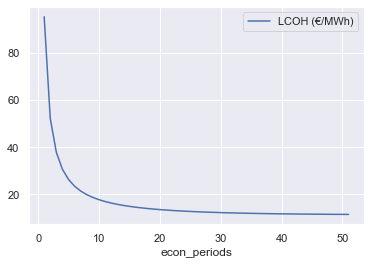

In [60]:
#compute LCOH
LCOH(dfBase600)

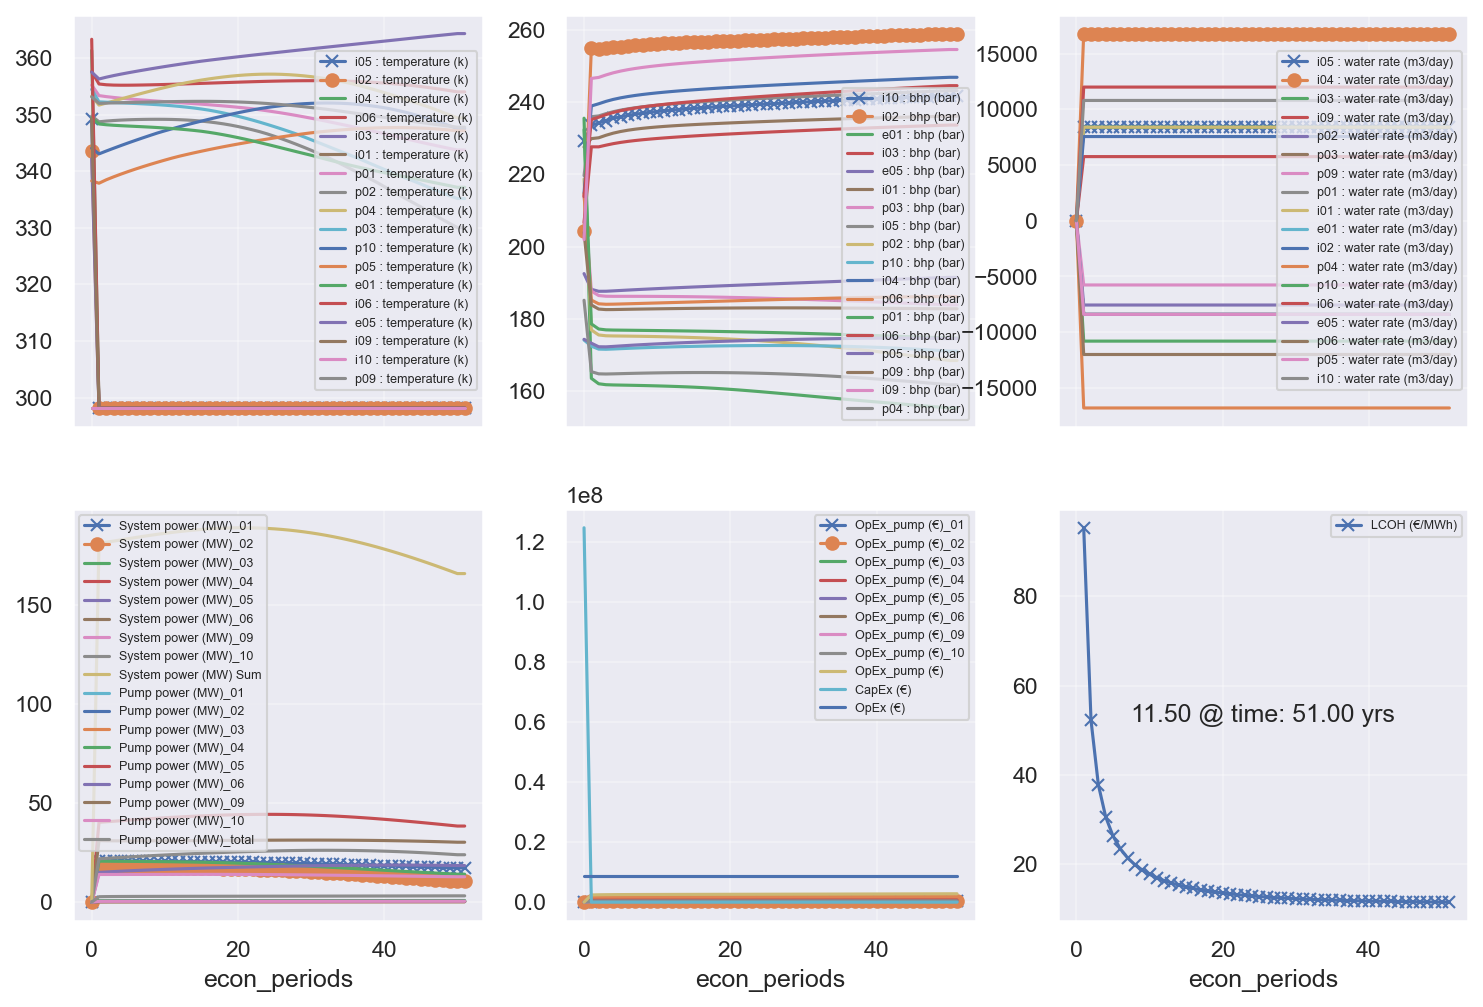

In [61]:
#visualise final econ plots
plotecon(dfBase600)

In [62]:
#compute npv for 50 years 
dfBase600 = netpv(dfBase600)

In [63]:
npv = dfBase600['pv (MM€)'].sum()
npv

2541.81284527873

In [64]:
#compute npv for 20 years
npv20 = dfBase600['pv (MM€)'].iloc[0:19].sum()
npv20 

1578.0876224311996

In [65]:
#compute LCOH at year 20
dfBase600['LCOH (€/MWh)'].iloc[19]

13.764428097836062

In [66]:
dfBase600.iloc[:,10:].head(3)

,i03 : water rate (m3/day),i02 : bhp (bar),e01 : energy (kj/day),i09 : water rate (m3/day),p02 : water rate (m3/day),p03 : water rate (m3/day),e01 : bhp (bar),i04 : energy (kj/day),p05 : energy (kj/day),i03 : bhp (bar),...,LCOH costs,discounted LCOH costs,discounted LCOH energy,LCOH (€/MWh),CapEx (MM€),OpEx (MM€),OpEx_pump (MM€),Revenue (MM€),NCF (MM€),pv (MM€)
0,-1.372648e-08,204.368622,0.000000e+00,-1.204592e-07,-6.055927e-08,-0.000005,235.548029,-8.978035e+00,-6.333518e-01,206.634874,...,1.334441e+08,1.334441e+08,0.000000e+00,inf,124.714074,8.729985,0.000000,-0.00,-133.444060,-133.444060
1,8.400000e+03,254.887856,-2.706220e+09,5.760000e+03,-7.560000e+03,-8400.000000,163.497029,2.147972e+09,-2.368220e+09,227.616488,...,1.113369e+07,1.440476e+08,1.510695e+06,95.351840,0.000000,8.729985,2.403704,157.68,146.546311,139.567915
2,8.400000e+03,254.571745,-2.700530e+09,5.760000e+03,-7.560000e+03,-8400.000000,161.998808,2.149051e+09,-2.387667e+09,227.613313,...,1.118733e+07,1.541948e+08,2.953716e+06,52.203672,0.000000,8.729985,2.457343,157.68,146.492672,132.873172


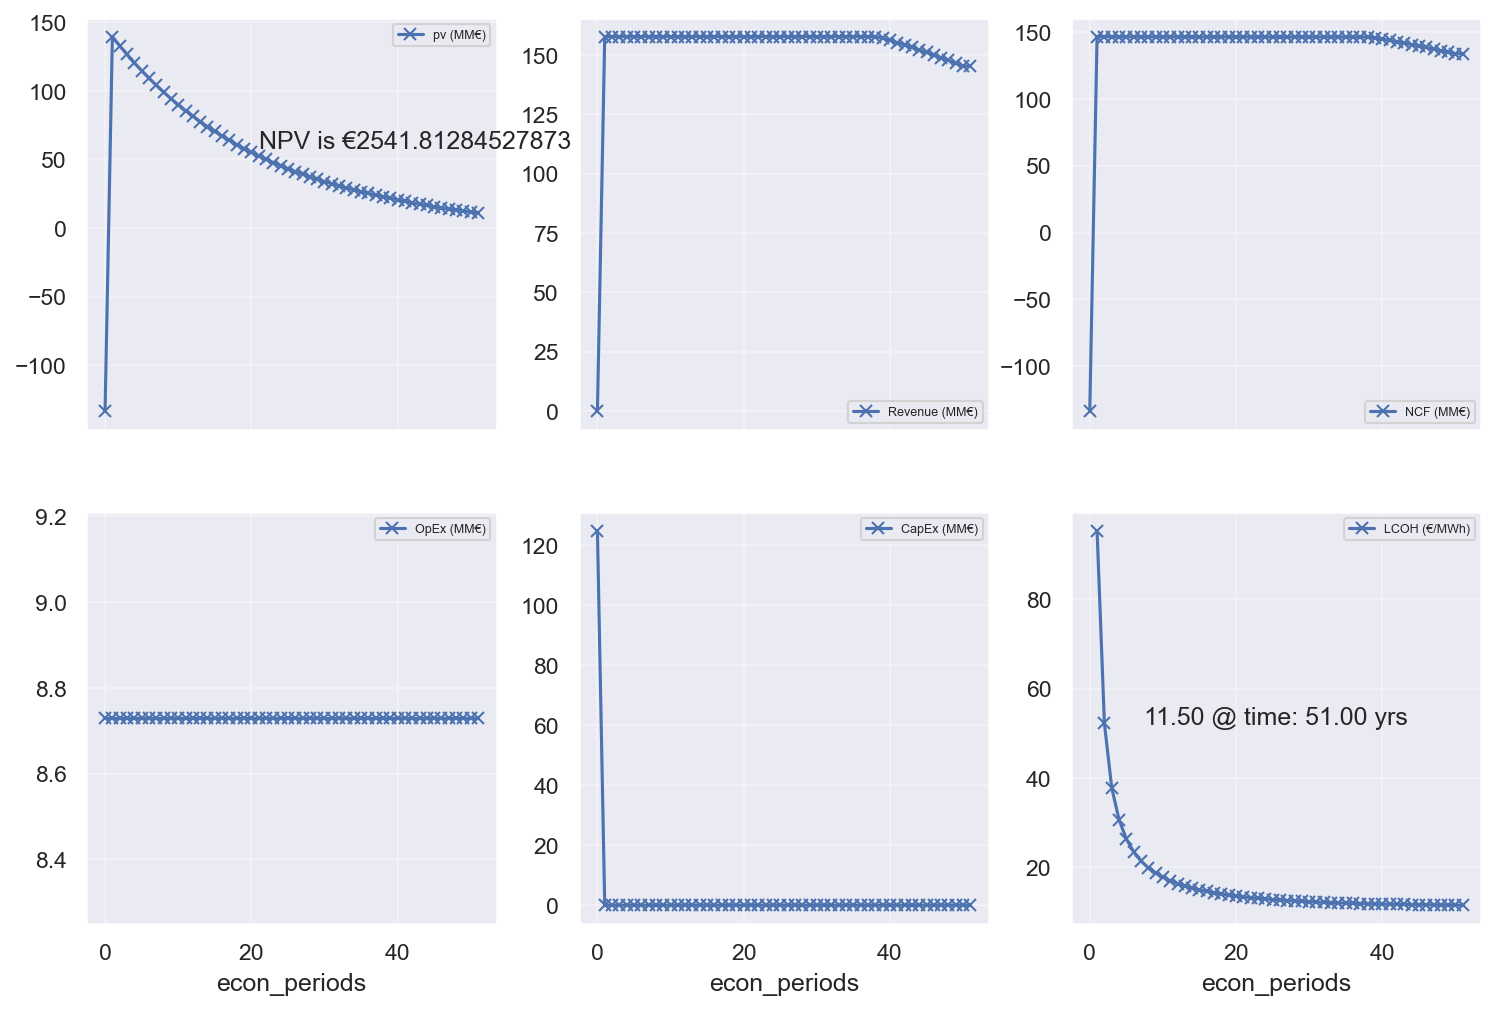

In [67]:
plotecon2(dfBase600)

---------------------------------------------------------------------------------------------------------
### To recap, we have run the DART simulator multiple times, varying input parameters each time
A. Well location 
B. Well Types
C. Rates
(Done for both new and existing)

### We clean and process the output file using "4_DARTS_cleanup.ipnyb" , after which we use the code above to generate 1 single value of

1. System power (MW) Sum (line 58 of above code)
2. NPV (line 64 of the above code)
3. LCOH (line 65 of above code)

In this example, the outputs for (1), (2) and (3) are 3339.1 MW, 1578 MM€ and 13.8@ 20 years.

We take the values of A, B and C along with 1, 2 and 3 and manually update an excel sheet, which we call "DARTS output.csv" and which we provide in Sect3.6_3.7_Model_DARTS of this submission